In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #@TODO include in some setup file

from simulation_engine.scenarios.iv.binary_iv import BinaryIV
from simulation_engine.scenarios.conf.binary_conf import BinaryConf
from simulation_engine.scenarios.iv.continuous_iv import ContinuousIV
from simulation_engine.util.plotting_util import PlottingUtil

import pandas as pd
pd.set_option('display.max_columns', None)

#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import math
# from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.neural_network import MLPClassifier
# Train a decision tree classifier to predict 'tightest_bounds'
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from simulation_engine.util.plotting_util import PlottingUtil
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np




In [2]:
import re

#setup
results = pd.read_pickle('17_06/results.pkl')
binaryIV = BinaryIV('IV DAG', results)
ATE_algs = binaryIV.get_algorithms('ATE')
PNS_algs = binaryIV.get_algorithms('PNS')
algs = ATE_algs + PNS_algs
results.columns.tolist()


['seed',
 'intercept_X',
 'intercept_Y',
 'b_Z_X',
 'b_U_X',
 'b_X_Y',
 'b_U_Y',
 'ATE_true',
 'PNS_true',
 'p_Y1_mean',
 'p_Y0_mean',
 'p_U',
 'p_Z',
 'Z',
 'U',
 'X',
 'Y',
 'epsilon_X',
 'sigma_X_vec',
 'epsilon_Y',
 'sigma_Y_vec',
 'entropy_Z',
 'entropy_U',
 'entropy_X',
 'entropy_Y',
 'squasher_X_name',
 'squasher_Y_name',
 'heteroskedasticity_structure',
 'ATE_2SLS-0.99_bound_lower',
 'ATE_2SLS-0.99_bound_upper',
 'ATE_2SLS-0.99_bound_valid',
 'ATE_2SLS-0.99_bound_width',
 'ATE_2SLS-0.99_bound_failed',
 'ATE_2SLS-0.98_bound_lower',
 'ATE_2SLS-0.98_bound_upper',
 'ATE_2SLS-0.98_bound_valid',
 'ATE_2SLS-0.98_bound_width',
 'ATE_2SLS-0.98_bound_failed',
 'ATE_2SLS-0.95_bound_lower',
 'ATE_2SLS-0.95_bound_upper',
 'ATE_2SLS-0.95_bound_valid',
 'ATE_2SLS-0.95_bound_width',
 'ATE_2SLS-0.95_bound_failed',
 'ATE_causaloptim_bound_lower',
 'ATE_causaloptim_bound_upper',
 'ATE_causaloptim_bound_valid',
 'ATE_causaloptim_bound_width',
 'ATE_causaloptim_bound_failed',
 'PNS_causaloptim_boun

                    Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width Invalid Δ (%)
           ATE_zaffalonbounds          0.00             5.70          0.5694      0.6509          1.08
       ATE_entropybounds-0.10          0.00            23.40          0.6722      0.9829          4.69
              ATE_causaloptim          0.90             5.65          0.7459      0.8274          2.59
                ATE_autobound          4.05             0.99          0.8015      0.8614          2.51
       ATE_entropybounds-0.20          0.00            11.10          0.8251      0.9555          4.70
                ATE_tianpearl          0.00             6.65          0.8738      0.9487          2.09
ATE_entropybounds-randomTheta          0.00            12.50          0.9205      1.0554          5.88
  ATE_entropybounds-trueTheta          0.00             9.35          0.9724      1.0685          5.44
       ATE_entropybounds-0.80          0.00             8.50          0.9

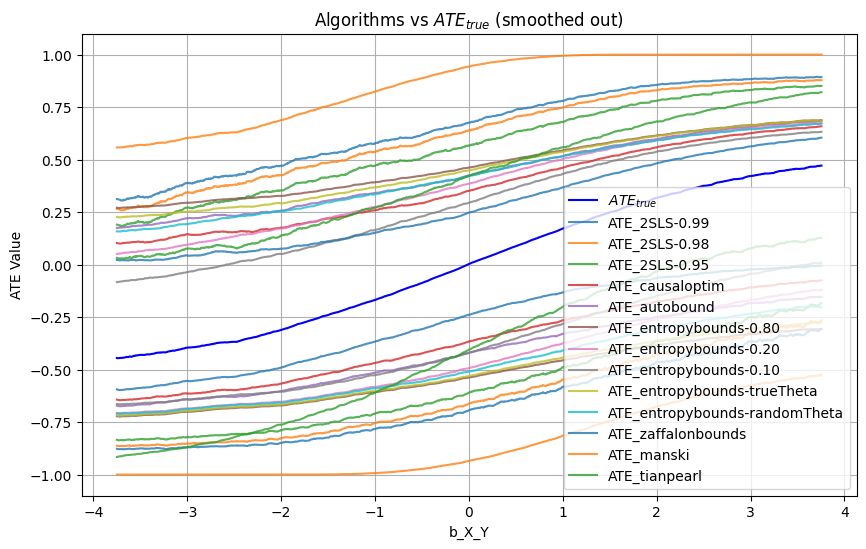

In [4]:
#ATE Evaluation
# Extract unique algorithm names from columns like 'ATE_{algorithm_name}_{...}'
df = results
algorithm_names = PlottingUtil.extract_algorithm_names(df, 'ATE')
PlottingUtil.print_bound_statistics_table(df, algorithm_names)
PlottingUtil.plot_smoothed_query_vs_bounds(df, 'ATE', algorithm_names, 500)

                    Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width Invalid Δ (%)
                PNS_tianpearl          0.00            26.40          0.1560      0.3788          2.74
           PNS_zaffalonbounds          0.00             0.60          0.4196      0.4231          0.93
              PNS_causaloptim          5.15            17.13          0.4323      0.5538          7.40
                PNS_autobound          4.05             1.72          0.4369      0.4690          1.96
       PNS_entropybounds-0.10          0.00             0.15          0.4890      0.4898          0.00
       PNS_entropybounds-0.20          0.00             0.05          0.5678      0.5680          0.00
PNS_entropybounds-randomTheta          0.00             0.05          0.6286      0.6288          0.00
  PNS_entropybounds-trueTheta          0.00             0.05          0.6851      0.6853          0.00
       PNS_entropybounds-0.80          0.00             0.00          0.7

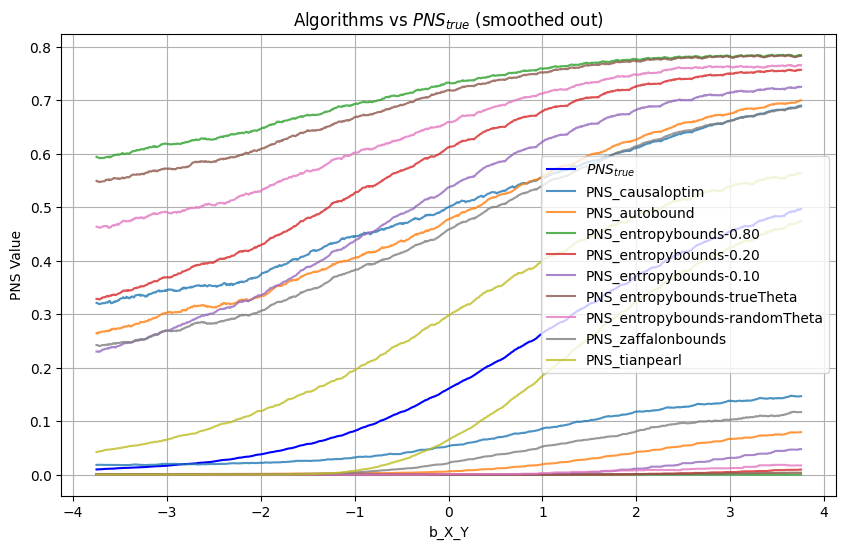

,seed,intercept_X,intercept_Y,b_Z_X,b_U_X,b_X_Y,b_U_Y,ATE_true,PNS_true,p_Y1_mean,p_Y0_mean,p_U,p_Z,Z,U,X,Y,epsilon_X,sigma_X_vec,epsilon_Y,sigma_Y_vec,entropy_Z,entropy_U,entropy_X,entropy_Y,squasher_X_name,squasher_Y_name,heteroskedasticity_structure,ATE_2SLS-0.99_bound_lower,ATE_2SLS-0.99_bound_upper,ATE_2SLS-0.99_bound_valid,ATE_2SLS-0.99_bound_width,ATE_2SLS-0.99_bound_failed,ATE_2SLS-0.98_bound_lower,ATE_2SLS-0.98_bound_upper,ATE_2SLS-0.98_bound_valid,ATE_2SLS-0.98_bound_width,ATE_2SLS-0.98_bound_failed,ATE_2SLS-0.95_bound_lower,ATE_2SLS-0.95_bound_upper,ATE_2SLS-0.95_bound_valid,ATE_2SLS-0.95_bound_width,ATE_2SLS-0.95_bound_failed,ATE_causaloptim_bound_lower,ATE_causaloptim_bound_upper,ATE_causaloptim_bound_valid,ATE_causaloptim_bound_width,ATE_causaloptim_bound_failed,PNS_causaloptim_bound_lower,PNS_causaloptim_bound_upper,PNS_causaloptim_bound_valid,PNS_causaloptim_bound_width,PNS_causaloptim_bound_failed,ATE_autobound_bound_lower,ATE_autobound_bound_upper,ATE_autobound_bound_valid,ATE_autobound_bound_width,ATE_autobound_bound_failed,PNS_autobound_bound_lower,PNS_autobound_bound_upper,PNS_autobound_bound_valid,PNS_autobound_bound_width,PNS_autobound_bound_failed,ATE_entropybounds-0.80_bound_lower,ATE_entropybounds-0.80_bound_upper,ATE_entropybounds-0.80_bound_valid,ATE_entropybounds-0.80_bound_width,ATE_entropybounds-0.80_bound_failed,ATE_entropybounds-0.80_theta,ATE_entropybounds-0.20_bound_lower,ATE_entropybounds-0.20_bound_upper,ATE_entropybounds-0.20_bound_valid,ATE_entropybounds-0.20_bound_width,ATE_entropybounds-0.20_bound_failed,ATE_entropybounds-0.20_theta,ATE_entropybounds-0.10_bound_lower,ATE_entropybounds-0.10_bound_upper,ATE_entropybounds-0.10_bound_valid,ATE_entropybounds-0.10_bound_width,ATE_entropybounds-0.10_bound_failed,ATE_entropybounds-0.10_theta,PNS_entropybounds-0.80_bound_lower,PNS_entropybounds-0.80_bound_upper,PNS_entropybounds-0.80_bound_valid,PNS_entropybounds-0.80_bound_width,PNS_entropybounds-0.80_bound_failed,PNS_entropybounds-0.80_theta,PNS_entropybounds-0.20_bound_lower,PNS_entropybounds-0.20_bound_upper,PNS_entropybounds-0.20_bound_valid,PNS_entropybounds-0.20_bound_width,PNS_entropybounds-0.20_bound_failed,PNS_entropybounds-0.20_theta,PNS_entropybounds-0.10_bound_lower,PNS_entropybounds-0.10_bound_upper,PNS_entropybounds-0.10_bound_valid,PNS_entropybounds-0.10_bound_width,PNS_entropybounds-0.10_bound_failed,PNS_entropybounds-0.10_theta,PNS_entropybounds-trueTheta_bound_lower,PNS_entropybounds-trueTheta_bound_upper,PNS_entropybounds-trueTheta_bound_valid,PNS_entropybounds-trueTheta_bound_width,PNS_entropybounds-trueTheta_bound_failed,PNS_entropybounds-trueTheta_theta,ATE_entropybounds-trueTheta_bound_lower,ATE_entropybounds-trueTheta_bound_upper,ATE_entropybounds-trueTheta_bound_valid,ATE_entropybounds-trueTheta_bound_width,ATE_entropybounds-trueTheta_bound_failed,ATE_entropybounds-trueTheta_theta,PNS_entropybounds-randomTheta_bound_lower,PNS_entropybounds-randomTheta_bound_upper,PNS_entropybounds-randomTheta_bound_valid,PNS_entropybounds-randomTheta_bound_width,PNS_entropybounds-randomTheta_bound_failed,PNS_entropybounds-randomTheta_theta,ATE_entropybounds-randomTheta_bound_lower,ATE_entropybounds-randomTheta_bound_upper,ATE_entropybounds-randomTheta_bound_valid,ATE_entropybounds-randomTheta_bound_width,ATE_entropybounds-randomTheta_bound_failed,ATE_entropybounds-randomTheta_theta,ATE_zaffalonbounds_bound_lower,ATE_zaffalonbounds_bound_upper,ATE_zaffalonbounds_bound_valid,ATE_zaffalonbounds_bound_width,ATE_zaffalonbounds_bound_failed,PNS_zaffalonbounds_bound_lower,PNS_zaffalonbounds_bound_upper,PNS_zaffalonbounds_bound_valid,PNS_zaffalonbounds_bound_width,PNS_zaffalonbounds_bound_failed,ATE_manski_bound_lower,ATE_manski_bound_upper,ATE_manski_bound_width,ATE_manski_bound_failed,ATE_manski_bound_valid,ATE_tianpearl_bound_lower,ATE_tianpearl_bound_upper,ATE_tianpearl_bound_width,ATE_tianpearl_bound_failed,ATE_tianpearl_bound_valid,PNS_tianpearl_bound_lower,PNS_tianpearl_bound_upper,PNS_t

In [5]:
#PNS Evaluation
# subset = results[results['PNS_tianpearl_bound_valid'] == False]
subset = results
algorithm_names = PlottingUtil.extract_algorithm_names(subset, 'PNS')
PlottingUtil.print_bound_statistics_table(subset, algorithm_names, 'PNS')
PlottingUtil.plot_smoothed_query_vs_bounds(subset, 'PNS', algorithm_names, 500)
subset

# Invalid Prediction

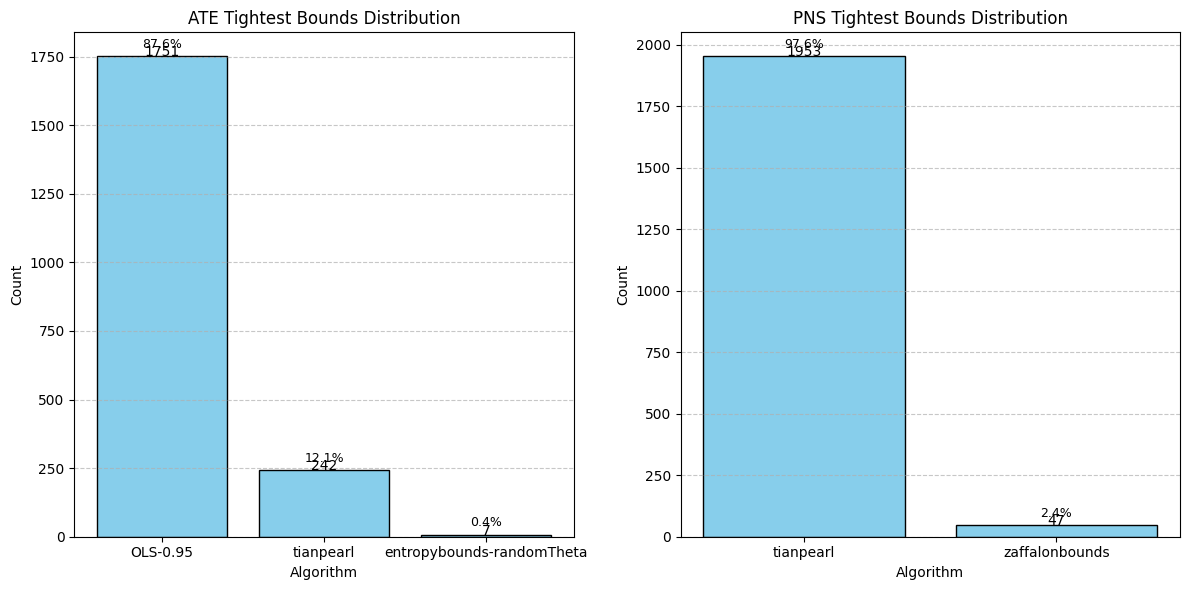

In [58]:
df = results.copy()
# Find tightest bounds without requiring bounds to be valid
# tb = PlottingUtil.compute_tightest_bound_valid(df)
tb = PlottingUtil.compute_tightest_bound(df)
PlottingUtil.plot_tightest_bounds_distribution(tb)


In [53]:
tb.columns.to_list()

['seed',
 'intercept_X',
 'intercept_Y',
 'b_U_X',
 'b_X_Y',
 'b_U_Y',
 'ATE_true',
 'PNS_true',
 'p_Y1_mean',
 'p_Y0_mean',
 'p_U',
 'U',
 'X',
 'Y',
 'epsilon_X',
 'sigma_X_vec',
 'epsilon_Y',
 'sigma_Y_vec',
 'entropy_U',
 'entropy_X',
 'entropy_Y',
 'squasher_X_name',
 'squasher_Y_name',
 'heteroskedasticity_structure',
 'ATE_OLS-0.99_bound_lower',
 'ATE_OLS-0.99_bound_upper',
 'ATE_OLS-0.99_bound_valid',
 'ATE_OLS-0.99_bound_width',
 'ATE_OLS-0.99_bound_failed',
 'ATE_OLS-0.98_bound_lower',
 'ATE_OLS-0.98_bound_upper',
 'ATE_OLS-0.98_bound_valid',
 'ATE_OLS-0.98_bound_width',
 'ATE_OLS-0.98_bound_failed',
 'ATE_OLS-0.95_bound_lower',
 'ATE_OLS-0.95_bound_upper',
 'ATE_OLS-0.95_bound_valid',
 'ATE_OLS-0.95_bound_width',
 'ATE_OLS-0.95_bound_failed',
 'ATE_causaloptim_bound_lower',
 'ATE_causaloptim_bound_upper',
 'ATE_causaloptim_bound_valid',
 'ATE_causaloptim_bound_width',
 'ATE_causaloptim_bound_failed',
 'PNS_causaloptim_bound_lower',
 'PNS_causaloptim_bound_upper',
 'PNS_causa

In [90]:
#Predict Invalid bounds

target_col = 'ATE_OLS-0.99_bound_valid'
tb['corr_X_Y'] = tb.apply(
    lambda row: np.corrcoef(row['X'], row['Y'])[0, 1]
    if isinstance(row['X'], (np.ndarray, list)) and isinstance(row['Y'], (np.ndarray, list)) and len(row['X']) == len(row['Y'])
    else np.nan, axis=1
)
tb['corr_X_U'] = tb.apply(
    lambda row: np.corrcoef(row['X'], row['U'])[0, 1]
    if isinstance(row['X'], (np.ndarray, list)) and isinstance(row['U'], (np.ndarray, list)) and len(row['X']) == len(row['U'])
    else np.nan, axis=1
)
tb['corr_Y_U'] = tb.apply(
    lambda row: np.corrcoef(row['Y'], row['U'])[0, 1]
    if isinstance(row['Y'], (np.ndarray, list)) and isinstance(row['U'], (np.ndarray, list)) and len(row['Y']) == len(row['U'])
    else np.nan, axis=1
)

from sklearn.metrics import mutual_info_score

tb['mutualinf_X_Y'] = tb.apply(
    lambda row: mutual_info_score(row['X'], row['Y'])
    if isinstance(row['X'], (np.ndarray, list)) and isinstance(row['Y'], (np.ndarray, list)) and len(row['X']) == len(row['Y'])
    else np.nan, axis=1
)

feature_cols = ['entropy_X', 'entropy_Y', 'corr_X_Y', 'entropy_U']  # <-- replace with your actual column names

X = tb[feature_cols]
y = tb[target_col].astype(int)  # Convert boolean/object to integer (0/1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [91]:
# Logistic Regression
from statsmodels.discrete.discrete_model import Logit
logit_model = Logit(y_train, sm.add_constant(X_train))
logit_result = logit_model.fit(disp=0)  # disp=0 to suppress output
logit_pred = logit_result.predict(sm.add_constant(X_test)) > 0.5
print("Logistic Regression Classification Report:")
print(classification_report(y_test, logit_pred))
print(logit_result.summary())


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.95      1.00      0.98       382

    accuracy                           0.95       400
   macro avg       0.48      0.50      0.49       400
weighted avg       0.91      0.95      0.93       400

                              Logit Regression Results                              
Dep. Variable:     ATE_OLS-0.99_bound_valid   No. Observations:                 1600
Model:                                Logit   Df Residuals:                     1595
Method:                                 MLE   Df Model:                            4
Date:                      Wed, 18 Jun 2025   Pseudo R-squ.:                  0.1850
Time:                              11:00:53   Log-Likelihood:                -266.02
converged:                             True   LL-Null:                       -326.40
Covariance Type:                  n

C:\Users\tmari\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tmari\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tmari\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

We can predicit "entropy/I(X,Y) -> PNS_tianpearl_valid" with 90% accuracy

Heuristic: 
* run prediction
* if it says tianpearl_valid=1: use tianpearl
* if it says tianpearl_valid=0: use entropybounds-10


We also know: Given tianpearl_valid=0 -> tianpeal collapses to point estimate

In [89]:
#Random Forest

# Split, train, and evaluate
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.58      0.39      0.47        18
           1       0.97      0.99      0.98       382

    accuracy                           0.96       400
   macro avg       0.78      0.69      0.72       400
weighted avg       0.95      0.96      0.96       400

              precision    recall  f1-score   support

           0       0.58      0.39      0.47        18
           1       0.97      0.99      0.98       382

    accuracy                           0.96       400
   macro avg       0.78      0.69      0.72       400
weighted avg       0.95      0.96      0.96       400

